# Massively parallel Transition Path Sampling

In this notebook we will see how to perform a massively parallel Transition Path Sampling (TPS) simulation of the $\alpha$-helix to $\beta$-sheet transition of capped alanine dipeptide using `aimmd` and `asyncmd`. This notebook assumes familarity with the engine classes of `asyncmd`, so please have a look at the example notebooks there if in doubt.

Here we will use the locally running `GmxEngine` and `PyTrajectoryFunctionWrapper` classes (such that you can run it on your workstation or laptop), but you can easily perform a massively parallel TPS on a HPC cluster running SLURM by using the `SlurmGmxEngine` and `SlurmTrajectoryFunctionWrapper` classes instead. However, in that case you will probably want to use a larger (and more interessting) system than capped alanine dipeptide...

In [1]:
%matplotlib inline

In [14]:
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt
#import mdtraj as mdt
import MDAnalysis as mda
import asyncmd
import asyncmd.gromacs as asyncgmx
from asyncmd import Trajectory
import aimmd
import aimmd.distributed as aimmdd

In [15]:
# setup working directory

scratch_dir = "/home/think/scratch/aimmd_distributed/"
#scratch_dir = "."

workdir = os.path.join(scratch_dir, "PathSampling_from_EQ_mda_test2")

if not os.path.isdir(workdir):
    os.mkdir(workdir)

In [16]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [17]:
# have a look at the default logging level (the level used for the root logger)
print(LOGCONFIG["loggers"][""])
# have a look at the logger for aimmd
print(LOGCONFIG["loggers"]["aimmd"])
# and have a look at the log-level for the filehandler
print(LOGCONFIG["handlers"]["stdf"])
# the last two should both be `INFO`

{'level': 'WARN', 'handlers': ['stdf', 'warnout']}
{'level': 'INFO'}
{'class': 'logging.FileHandler', 'level': 'INFO', 'mode': 'w', 'filename': 'simulation.log', 'formatter': 'standardFormatter'}


In [18]:
# OPTIONAL: more logging to file
level = "INFO"
LOGCONFIG["handlers"]["stdf"]["level"] = level
LOGCONFIG["loggers"]["aimmd"]["level"] = level
LOGCONFIG["loggers"]["asyncmd"] = {"level": level}

In [19]:
# you can either modify single values or use it as is to get the same setup as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
import logging.config
LOGCONFIG["handlers"]["stdf"]["filename"] = os.path.join(workdir, "simulation_pathsampling.log")
LOGCONFIG["handlers"]["initf"]["filename"] = os.path.join(workdir, "initlog_pathsampling.log")
logging.config.dictConfig(LOGCONFIG)

# now the actual setup

In [20]:
n_samplers = 5  # results in 2*n_samplers gmx engines

In [21]:
storage = aimmd.Storage(os.path.join(workdir, "storage.h5"))

(WARNING)aimmd.base.storage __init__: Resetting the asyncmd h5py trajectory value cache. Was <HDF5 group "/aimmd_data/cache/distributed" (1 members)>.


In [22]:
# Define the engine(s) for the PathMovers
# (they will all be the same)
gro = "gmx_infiles/conf.gro"
top = "gmx_infiles/topol_amber99sbildn.top"
ndx = "gmx_infiles/index.ndx"
mdp = async_gmx.MDP("gmx_infiles/md.mdp")

gmx_engine_kwargs = {"mdconfig": mdp,
                     "gro_file": gro,
                     "top_file": top,
                     "ndx_file": ndx,
                     "output_traj_type": "XTC",
                     "mdrun_extra_args": "-nt 2",
                     # use this for gmx sans (thread) MPI
                     #"mdrun_extra_args": "-ntomp 2",
                     }
gmx_engine_cls = asyncgmx.GmxEngine

In [23]:
# state functions
from state_funcs_mda import alpha_R, C7_eq

wrapped_alphaR = asyncmd.trajectory.PyTrajectoryFunctionWrapper(alpha_R)

wrapped_C7_eq = asyncmd.trajectory.PyTrajectoryFunctionWrapper(C7_eq)

In [24]:
# descriptor_transform for the model

# internal coordinates
from state_funcs_mda import descriptor_func_ic, descriptor_func_psi_phi

wrapped_transform = asyncmd.trajectory.PyTrajectoryFunctionWrapper(descriptor_func_ic, call_kwargs={"molecule_selection": "protein"})
wrapped_psi_phi = asyncmd.trajectory.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

In [26]:
# define the US trajectory and calculate weights for reweighting to eq
path_to_us = "/home/think/scratch/aimmd_distributed/UmbrellaSampling"

us_traj = asyncmd.Trajectory(structure_file=os.path.join(path_to_us, "US.tpr"),
                             trajectory_files=os.path.join(path_to_us, "US.part0001.xtc"))
us_mdp = asyncgmx.MDP(os.path.join(path_to_us, "US.mdp"))

psi_phi_us = await wrapped_psi_phi(us_traj)

# now get the weights (as they differ from quilibrium)
from scipy import constants

# read the values directly from the US mdp
T = us_mdp["ref-t"][0]
k_psi = float(us_mdp["pull-coord1-k"][0]) # kJ/ (mol * rad**2)
psi_0 = float(us_mdp["pull-coord1-init"][0]) * np.pi / 180  # psi_0 in rad
k_phi = float(us_mdp["pull-coord2-k"][0]) # kJ/ (mol * rad**2)
phi_0 = float(us_mdp["pull-coord2-init"][0]) * np.pi / 180  # psi_0 in rad

# Note that gromacs uses the conventions:
#      U_bias = k/2 (x - x0)**2
#      F_bias = - k (x - x0)

def U_bias(x, x_0, k):
    return (k / 2) * (x - x_0) * (x - x_0)

beta = 1000 / (constants.R * T)  # beta in kJ /mol

################################################################################################################
weights = np.exp(-beta * ( U_bias(psi_phi_us[:, 0], psi_0, k_psi) + U_bias(psi_phi_us[:, 1], phi_0, k_phi) ))
##################################################################################################################

In [27]:
np.min(weights)

6.231927097683679e-06

In [28]:
np.max(weights)

0.9991798913854822

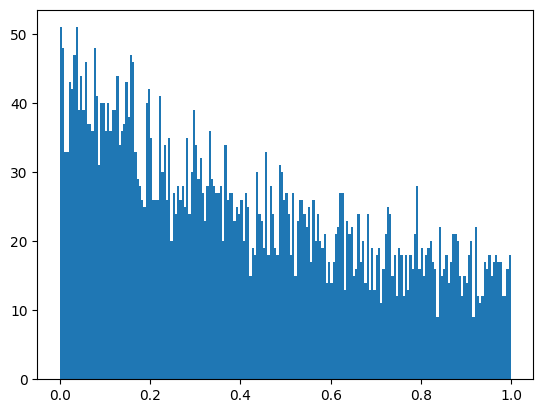

In [30]:
fig, axs = plt.subplots()

axs.hist(weights, bins=200);
#axs.set_xscale("log")
#axs.set_yscale("log")

### Define the model

In [31]:
descriptors_for_us = await wrapped_transform(us_traj)

In [32]:
# imports for model
import torch.nn.functional as F
import torch

In [33]:
# model definition
n_lay_pyramid = 5
n_unit_top = 10
dropout_base = 0.3
n_unit_base = cv_ndim = descriptors_for_us.shape[1]
fact = (n_unit_top / n_unit_base)**(1./(n_lay_pyramid))

modules = []

for i in range(1, n_lay_pyramid + 1):
    #print(f"ResUnit {i} is {max(n_unit_top, int(n_unit_base * fact**(i-1)))} units wide.")
    #modules += [aimmd.pytorch.networks.ResNet(n_units=max(n_unit_top, int(n_unit_base * fact**(i-1))),
    #                                          n_blocks=1)
    #            ]

    modules += [aimmd.pytorch.networks.FFNet(n_in=max(n_unit_top, int(n_unit_base * fact**(i-1))),
                                             n_hidden=[max(n_unit_top, int(n_unit_base * fact**i))],  # 1 hidden layer network
                                             activation=torch.nn.Identity(),
                                             dropout={"0": dropout_base * fact**i}
                                             )
                ]
    print(f"ResUnit {i} is {max(n_unit_top, int(n_unit_base * fact**(i)))} units wide.")
    print(f"Dropout before it is {dropout_base * fact**i}.")
    modules += [aimmd.pytorch.networks.ResNet(n_units=max(n_unit_top, int(n_unit_base * fact**i)),
                                              n_blocks=1)
                ]

torch_model = aimmd.pytorch.networks.ModuleStack(n_out=1,  # using a single output we will predict only p_B and use a binomial loss
                                                           # we could have also used n_out=n_states to use a multinomial loss and predict all states,
                                                           # but this is probably only worthwhile if n_states > 2 as it would increase the number of free parameters in the NN
                                                 modules=modules,  # modules is a list of initialized torch.nn.Modules from arcd.pytorch.networks
                                                 )

# move model to GPU if CUDA is available
if torch.cuda.is_available():
    torch_model = torch_model.to('cuda')

# choose and initialize an optimizer to train the model
optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-3)

ResUnit 1 is 66 units wide.
Dropout before it is 0.18674307214231128.
ResUnit 2 is 41 units wide.
Dropout before it is 0.1162432499771616.
ResUnit 3 is 25 units wide.
Dropout before it is 0.07235873872180604.
ResUnit 4 is 16 units wide.
Dropout before it is 0.045041643884176266.
ResUnit 5 is 10 units wide.
Dropout before it is 0.02803738317757008.


In [34]:
# we take an ExpectedEfficiencyPytorchRCModel,
# this RCmodel scales the learning rate by the expected efficiency factor (1 - n_TP_true / n_TP_expected)**2
model = aimmd.pytorch.EEScalePytorchRCModelAsync(nnet=torch_model,
                                                 optimizer=optimizer,
                                                 states=[wrapped_C7_eq, wrapped_alphaR],
                                                 ee_params={'lr_0': 1e-3,  
                                                            #'lr_min': 5e-5,  # lr_min = lr_0 / 20 is a good choice empirically
                                                            'lr_min': 5e-5,
                                                            'epochs_per_train': 3, # try 5, [10 and 15] next
                                                            #'epochs_per_train': 5,
                                                            'interval': 5,
                                                            #'interval': 10,
                                                            #'window': 75,
                                                            'window': 100,
                                                            'batch_size': 8192,
                                                           },
                                                 descriptor_transform=wrapped_transform,
                                                 cache_file=storage,
                                                 )

In [35]:
selector = aimmdd.spselectors.RCModelSPSelectorFromEQ(trajectories=us_traj, equilibrium_weights=weights, density_adaptation=True)

In [36]:
# we could use a list with initialized movers
#movers = [[aimmdd.TwoWayShootingPathMover(states=[wrapped_C7_eq, wrapped_alphaR],
#                                          engine_cls=gmx_engine_cls,
#                                          engine_kwargs=gmx_engine_kwargs,
#                                          engine_config=mdp,
#                                          walltime_per_part=0.01,
#                                          T=mdp["ref-t"][0],
#                                         )
#           ] for i in range(n_samplers)
#         ]

# it is easier though to use the `Brain.chains_from_moverlist()` function
# this function will create n-chain identical PathSamplingChains where the movers for each chain are
# specified by movers_cls (a list of mover classes) and movers_kwargs (a dict with keyword arguments used for initialization of the movers)
movers_cls = [aimmdd.pathmovers.TwoWayShootingPathMover]
movers_kwargs = [{'states': [wrapped_alphaR, wrapped_C7_eq],
                  'engine_cls': gmx_engine_cls,
                  'engine_kwargs': gmx_engine_kwargs,
                  # NOTE: choose this as short as possible!
                  #       since ala is super-small and commits fast we should make sure
                  #       that most trials reach a state in the first part
                  #       this in turn makes sure that we do not call gromasc multiple times per trial (saving setup time)
                  #       but still ensures that the resulting trajectories are not too long and large
                  #       it also reduces the time needed per step (we need at least walltime_per_part hours per step)
                  #'walltime_per_part': 0.000015625,  # 0.055125 s per part
                  'walltime_per_part': 0.00003125,  # 0.1125 s per part
                  #'walltime_per_part': 0.0000625,  # 0.225 s per part
                  #'walltime_per_part': 0.000125,  # 0.45 s per part
                  #'walltime_per_part': 0.00025,  # 0.9 s per part
                  #'walltime_per_part': 0.0005,  # 1.8 s per part
                  #'walltime_per_part': 0.001,  # 3.6 s per part
                  #'walltime_per_part': 0.002,  # 7.2 s per part
                  #'walltime_per_part': 0.003,  # 10.8 s per part
                  #'walltime_per_part': 0.004,  # 14.4 s per part
                  'T': mdp["ref-t"][0],
                  "sp_selector": selector,  # can be used to customize SP-selection params 
                  "max_steps": 500 * 10**5,  # 500 steps * dt (2 fs) = 1 ps
                  }
                 ]

In [37]:
trainset = aimmd.TrainSet(n_states=2)

In [38]:
tasks = [aimmdd.pathsampling.TrainingTask(model=model, trainset=trainset),
         aimmdd.pathsampling.SaveTask(storage=storage, model=model, trainset=trainset),
         # TODO/FIXME: density collection does not make sense (and also does only work if every accepted MCStep has a trajectory associated)
         aimmdd.pathsampling.DensityCollectionTask(model=model,
                                                   first_collection=100,
                                                   recreate_interval=100,
                                                   mode="custom",
                                                   trajectories=[us_traj],
                                                   trajectory_weights=[weights],
                                                   interval=10
                                                   ),
         ]

In [39]:
# this would be the full __init__ call to the brain
# it gives you full flexibility of setting up every PathSamplingChain individually
#brain = aimmdd.Brain(model=model, workdir=workdir, storage=storage, movers=movers, mover_weights=[[1.], [1.], [1.]], tasks=tasks)

# this is the 'easy' way
brain = aimmdd.Brain.samplers_from_moverlist(model=model, workdir=workdir, storage=storage,
                                             n_sampler=n_samplers,
                                             movers_cls=movers_cls, movers_kwargs=movers_kwargs,
                                             samplers_use_same_stepcollection=True,
                                             tasks=tasks)
                                           # Note that we left mover_weights=None at its default, this results
                                           # in uniform weights for all movers

# TODO: Seeding the initial MCSteps does not work (we expect initial paths!)

In [40]:
"""
# NOTE: old cumbersome setup

#initial_step = aimmdd.logic.MCstep(mover=None, stepnum=0, directory="gmx_infiles", path=tp_short, accepted=True)
#initial_step2 = aimmdd.logic.MCstep(mover=None, stepnum=0, directory="gmx_infiles", path=tp_long, accepted=True)

# take two different initial TPs
#for i, c in enumerate(brain.chains):
#    if i == 2:
#        c.current_step = initial_step2
#        c.chainstore.append(initial_step2)  # save the initial step as first step of every chain
#    else:
#        c.current_step = initial_step
#        c.chainstore.append(initial_step)  # save the initial step as first step of every chain


# NEW: use the new seed_initial_paths() method!
# have a look at before
for i, s in enumerate(brain.samplers):
    print(f"Sampler {i}: ", s.current_step)
    print()
# seed them
#brain.seed_initial_paths(trajectories=[tp_lb, tp_short, tp_short2], weights=[1., 1., 1.])
for i, s in enumerate(brain.samplers):
    s.current_step = aimmdd.pathmovers.MCstep(None, stepnum=0, directory=os.getcwd(), accepted=True)

# have a look again
for i, s in enumerate(brain.samplers):
    print(f"Sampler {i}: ")
    print(f"{s.current_step}, with path {s.current_step.path}.")
    print()
"""

'\n# NOTE: old cumbersome setup\n\n#initial_step = aimmdd.logic.MCstep(mover=None, stepnum=0, directory="gmx_infiles", path=tp_short, accepted=True)\n#initial_step2 = aimmdd.logic.MCstep(mover=None, stepnum=0, directory="gmx_infiles", path=tp_long, accepted=True)\n\n# take two different initial TPs\n#for i, c in enumerate(brain.chains):\n#    if i == 2:\n#        c.current_step = initial_step2\n#        c.chainstore.append(initial_step2)  # save the initial step as first step of every chain\n#    else:\n#        c.current_step = initial_step\n#        c.chainstore.append(initial_step)  # save the initial step as first step of every chain\n\n\n# NEW: use the new seed_initial_paths() method!\n# have a look at before\nfor i, s in enumerate(brain.samplers):\n    print(f"Sampler {i}: ", s.current_step)\n    print()\n# seed them\n#brain.seed_initial_paths(trajectories=[tp_lb, tp_short, tp_short2], weights=[1., 1., 1.])\nfor i, s in enumerate(brain.samplers):\n    s.current_step = aimmdd.path

In [41]:
import time

In [42]:
n_steps = 2500
start = time.time()

await brain.run_for_n_steps(n_steps)
#await brain.run_for_n_steps(2000)
#await brain.run_for_n_accepts(25)

end = time.time()
print(f"Running for {n_steps} cummulative MCSteps took {end-start} s (= {(end-start)/60} min).")

(WARNING)aimmd.distributed.pathsampling run_step: Sampler 0: Instep is None. This will only work with sampling schemes that generate their own shooting points.
(WARNING)aimmd.distributed.pathsampling run_step: Sampler 1: Instep is None. This will only work with sampling schemes that generate their own shooting points.
(WARNING)aimmd.distributed.pathsampling run_step: Sampler 2: Instep is None. This will only work with sampling schemes that generate their own shooting points.
(WARNING)aimmd.distributed.pathsampling run_step: Sampler 3: Instep is None. This will only work with sampling schemes that generate their own shooting points.
(WARNING)aimmd.distributed.pathsampling run_step: Sampler 4: Instep is None. This will only work with sampling schemes that generate their own shooting points.


Running for 2500 cummulative MCSteps took 3428.706876039505 s (= 57.14511460065842 min).


In [43]:
brain.total_steps

2500

In [44]:
print(model.log_train_decision[-1])

[False, 5.65860162405232e-06, 3, 8192]


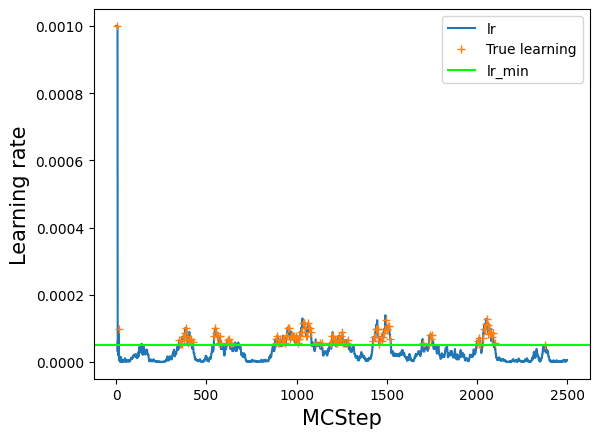

In [45]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

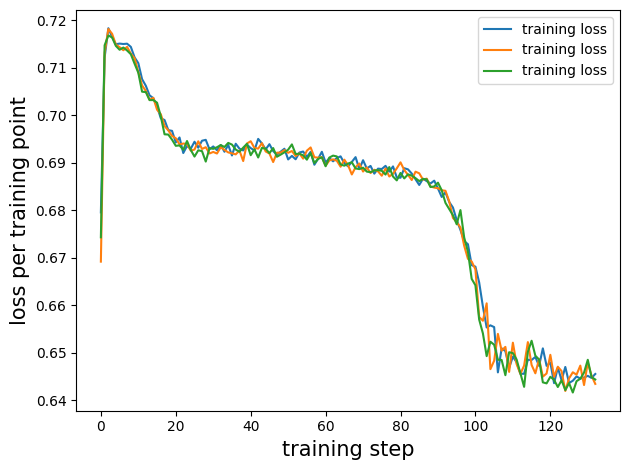

In [46]:
# the model losses at each step where it trained
# this will be epochs_per_training loss values per training
plt.plot(model.log_train_loss, label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('training step', size=15)
plt.tight_layout()

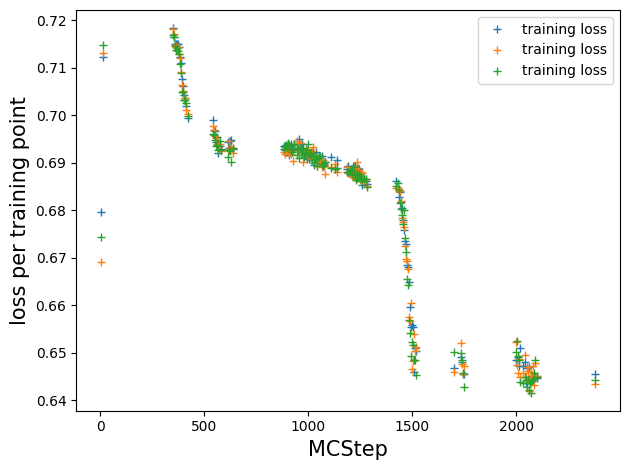

In [47]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

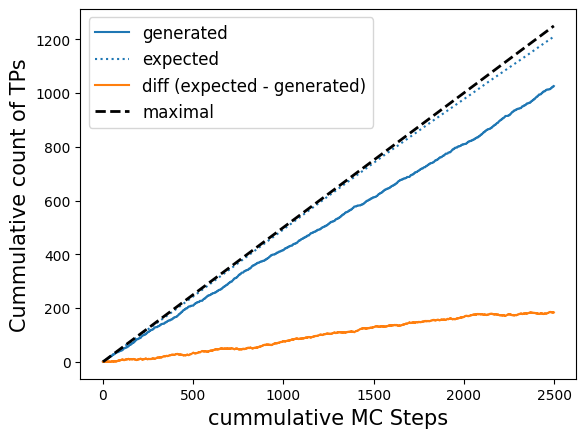

In [48]:
# plot efficiency, expected efficiency and accepts
# Note: this will only work for models with n_out=1, due to the way we calculate p(TP|x)

p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
#plt.plot(np.cumsum(brain.accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (expected - generated)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=12);
plt.ylabel('Cummulative count of TPs', size=15)
plt.xlabel('cummulative MC Steps', size=15);

In [49]:
hipr = aimmd.analysis.HIPRanalysis(model, trainset)

In [50]:
hipr_plus_losses, hipr_plus_stds = hipr.do_hipr_plus(25)

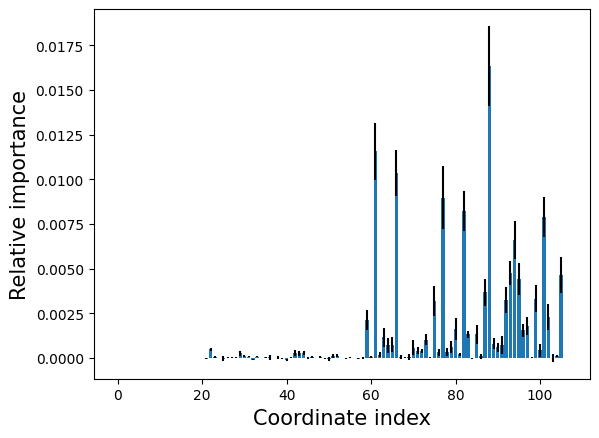

In [51]:
loss_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset

plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_plus_stds[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [52]:
# what are the most important contributors?
max_idxs = np.argsort(loss_diffs)[::-1]

# import the function used to generate the internal coordinate representation for the molecule
from state_funcs_mda import generate_atomgroups_for_ic

# and use it to get lists of pairs (distances), triples (angles) and quadruples ([pseudo-]dihedrals)
u = mda.Universe("gmx_infiles/ala_300K_amber99sb-ildn.tpr", "gmx_infiles/conf.gro",
                 refresh_offsets=True, tpr_resid_from_one=True)
molecule = u.select_atoms('protein')
pairs, triples, quadruples = generate_atomgroups_for_ic(molecule)

def pprint_atom(at):
    """Helper function to print atom information in a nice way."""
    ret = f"Atom {at.ix+1}:"
    if hasattr(at, "name"):
        ret += f" {at.name}"
    if hasattr(at, "resname"):
        ret += f" in residue {at.resname}"
    if hasattr(at, "resid"):
        ret += f" (resid {at.resid})"
    return ret

# now use all of this to print the most relevant coordinates in a remotely human understandable fashion
print('reference loss:', hipr_plus_losses[-1])
for idx in max_idxs[:6]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_plus_losses[idx], f" (loss diff= {hipr_plus_losses[idx] - hipr_plus_losses[-1]})")
    if idx < len(pairs[0]):
        print(f"bond between: {pprint_atom(pairs[0][idx])} and {pprint_atom(pairs[1][idx])}")
        continue
    idx -= len(pairs[0])
    if idx < len(triples[0]):
        print(f"angle between {pprint_atom(triples[0][idx])}, {pprint_atom(triples[1][idx])} and {pprint_atom(triples[2][idx])}")
        continue
    idx -= len(triples[0])
    if idx % 2 == 0:
        st = "sinus"
    else:
        st = "cosinus"
    st += f" of dihedral between {pprint_atom(quadruples[0][idx // 2])}, {pprint_atom(quadruples[1][idx // 2])}, {pprint_atom(quadruples[2][idx // 2])}"
    st += f" and {pprint_atom(quadruples[3][idx // 2])}."
    print(st)

reference loss: 0.639145751953125

loss for idx 88:  0.65549762109375  (loss diff= 0.01635186914062503)
cosinus of dihedral between Atom 10: HA in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2), Atom 11: CB in residue ALA (resid 2) and Atom 12: HB1 in residue ALA (resid 2).

loss for idx 61:  0.65070962890625  (loss diff= 0.011563876953124996)
sinus of dihedral between Atom 2: HH31 in residue ACE (resid 1), Atom 1: CH3 in residue ACE (resid 1), Atom 5: C in residue ACE (resid 1) and Atom 6: O in residue ACE (resid 1).

loss for idx 66:  0.649474921875  (loss diff= 0.010329169921875048)
cosinus of dihedral between Atom 4: HH33 in residue ACE (resid 1), Atom 1: CH3 in residue ACE (resid 1), Atom 5: C in residue ACE (resid 1) and Atom 6: O in residue ACE (resid 1).

loss for idx 77:  0.6481249082031251  (loss diff= 0.00897915625000012)
sinus of dihedral between Atom 7: N in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2), Atom 11: CB in residue ALA (resid 2) and Ato

In [53]:
# save the last model
storage.rcmodels["model_to_continue_with"] = model
storage.save_trainset(trainset)
storage.save_brain(brain)

In [54]:
len(storage.load_trainset())

2500

In [55]:
list(storage.rcmodels.keys())

['Central_RCModel_after_step100',
 'Central_RCModel_after_step1000',
 'Central_RCModel_after_step1100',
 'Central_RCModel_after_step1200',
 'Central_RCModel_after_step1300',
 'Central_RCModel_after_step1400',
 'Central_RCModel_after_step1500',
 'Central_RCModel_after_step1600',
 'Central_RCModel_after_step1700',
 'Central_RCModel_after_step1800',
 'Central_RCModel_after_step1900',
 'Central_RCModel_after_step200',
 'Central_RCModel_after_step2000',
 'Central_RCModel_after_step2100',
 'Central_RCModel_after_step2200',
 'Central_RCModel_after_step2300',
 'Central_RCModel_after_step2400',
 'Central_RCModel_after_step2500',
 'Central_RCModel_after_step300',
 'Central_RCModel_after_step400',
 'Central_RCModel_after_step500',
 'Central_RCModel_after_step600',
 'Central_RCModel_after_step700',
 'Central_RCModel_after_step800',
 'Central_RCModel_after_step900',
 'model_to_continue_with']

In [57]:
storage.close()

ValueError: Invalid location identifier (invalid location identifier)